In [1]:
%matplotlib inline

In [25]:
from Bio import SeqIO
from matplotlib import pyplot as plt
from scipy import stats

import pandas as pd
import numpy as np

# Needed a .fasta file of all transcripts to make Neisseria transcriptome index for Kallisto
(relevant files already exist in `../Data/Data_release/` so this code does not need to be re-run, simply provided for those interested)

In [44]:
genome = list(SeqIO.parse('../Data_release/fa1090.gb', 'genbank'))

In [45]:
assert len(genome) == 1
genome = genome[0]
print(len(genome.seq))

2153922


In [46]:
output_handle = open('../Data_release/fa1090.annotatedCDS.fasta', "w")
for feature in genome.features:
    if feature.type == 'CDS':
        if 'locus_tag' in feature.qualifiers:
            gene_name = feature.qualifiers['locus_tag'][0]
        else:
            continue
    else:
        continue
    output_handle.write(">" + gene_name + "\n" + str(feature.extract(genome.seq)) + "\n")
output_handle.close()

# Offline

Ran Kallisto using `kallisto_all.sh` script to loop over all sample files that we analyzed (named SQ-1...SQ-12 in our oringal format, although names have been changed upon uploading to GEO for clarity of conditions/replicates). Input `.fastq` files (available at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE114819)

We ran Kallisto by mapping to both the full Neisseria genome (for visualization of read coverage and annotation via dRNA-seq) as well as just annotated transcripts (for differential expression analysis).

This script should run both analysis including the creation of `.wig` files for the genome mapping

Next, we ran SLEUTH for differential expression analysis

# Reading/interpreting Kallisto datatables 

(in the old naming convention SQ-1,3,5 were control and SQ-2,4,6 were h202 treated, thus the groupings you see below)

In [26]:
df1 = pd.read_csv('../Data_release/sleuth_test_table.csv', index_col='target_id')
df1 = df1.drop('Unnamed: 0', 1)
df2 = pd.read_csv('../Data_release/kallisto_results_table.csv')
df2 = df2.drop('Unnamed: 0', 1)

In [27]:
for i in ['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6']:
    df1[i] = ''

In [28]:
print(df2.columns)

Index(['target_id', 'sample', 'est_counts', 'tpm', 'eff_len', 'len'], dtype='object')


In [29]:
for index in df2.index:
    df1.ix[df2.loc[index]['target_id'], df2.loc[index]['sample']] = df2.loc[index]['tpm']

/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


In [30]:
df1['avg(SQ1,SQ3,SQ5)'] = np.nan
df1['avg(SQ2,SQ4,SQ6)'] = np.nan
df1['log2_FC'] = np.nan
for index in df1.index:
    try:
        df1.ix[index, 'avg(SQ2,SQ4,SQ6)'] = np.mean([df1.loc[index]['SQ2'], df1.loc[index]['SQ4'], df1.loc[index]['SQ6']])
    except TypeError:
        pass
    try:
        df1.ix[index, 'avg(SQ1,SQ3,SQ5)'] = np.mean([df1.loc[index]['SQ1'], df1.loc[index]['SQ3'], df1.loc[index]['SQ5']])
    except TypeError:
        pass
    try:
        df1.ix[index, 'log2_FC'] = np.log2(np.exp(df1.ix[index, 'b']))
    except TypeError:
        pass

In [31]:
df1.columns

Index(['pval', 'qval', 'b', 'se_b', 'mean_obs', 'var_obs', 'tech_var',
       'sigma_sq', 'smooth_sigma_sq', 'final_sigma_sq', 'SQ1', 'SQ2', 'SQ3',
       'SQ4', 'SQ5', 'SQ6', 'avg(SQ1,SQ3,SQ5)', 'avg(SQ2,SQ4,SQ6)', 'log2_FC'],
      dtype='object')

In [32]:
df_compact = df1[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'avg(SQ1,SQ3,SQ5)', 'avg(SQ2,SQ4,SQ6)', 'log2_FC', 'qval', 'pval']]

In [33]:
df_compact_sorted = df_compact.sort_index(axis=0)

In [34]:
df_best = df_compact[(abs(df_compact.log2_FC) > 1) & (df_compact.qval < 0.05)]
len(df_best.index)

52

# Writing those data table results which were our significant findings

Commenting them out here

In [ ]:
# writer = pd.ExcelWriter('../Data_release/compact_table_04_27_17.xlsx', engine='xlsxwriter')
# df_compact.to_excel(writer, sheet_name='Sheet1')
# writer.save()
# writer = pd.ExcelWriter('../Data_release/compact_table_sorted_04_27_17.xlsx', engine='xlsxwriter')
# df_compact_sorted.to_excel(writer, sheet_name='Sheet1')
# writer.save()
# writer = pd.ExcelWriter('../Data_release/compact_table_best_04_27_17.xlsx', engine='xlsxwriter')
# df_best.to_excel(writer, sheet_name='Sheet1')
# writer.save()

# Making figures from those data files

Probably should read the outputs back in but this notebook is currently written as a bit of a one-stop-shop for our entire pipeline

In [37]:
df_compact = df_compact.loc[df_compact['log2_FC'].isnull() == False]

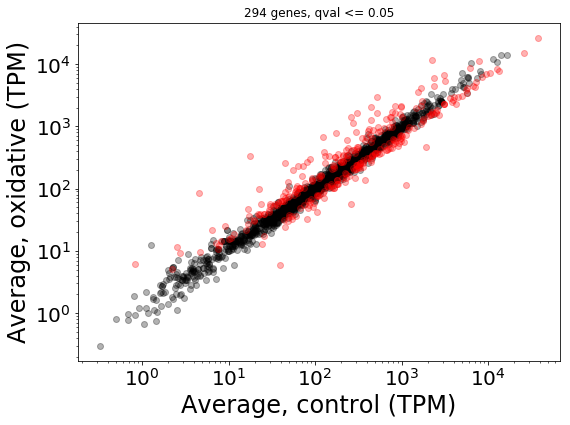

In [38]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
x_data = df_compact.loc[df_compact['qval'] > 0.05]['avg(SQ1,SQ3,SQ5)']
y_data = df_compact.loc[df_compact['qval'] > 0.05]['avg(SQ2,SQ4,SQ6)']
ax1.loglog(x_data, y_data, 'ko', alpha=0.3)
x_data = df_compact.loc[df_compact['qval'] <= 0.05]['avg(SQ1,SQ3,SQ5)']
y_data = df_compact.loc[df_compact['qval'] <= 0.05]['avg(SQ2,SQ4,SQ6)']
ax1.loglog(x_data, y_data, 'ro', alpha=0.3)

ax1.tick_params(labelsize=20)
ax1.set_xlabel('Average, control (TPM)', fontsize=24)
ax1.set_ylabel('Average, oxidative (TPM)', fontsize=24)
ax1.set_title('{} genes, qval <= 0.05'.format(len(y_data)))
plt.tight_layout()

52
LinregressResult(slope=0.85375382051660242, intercept=1.575670168935364, rvalue=0.86633174768368915, pvalue=1.0846571494116426e-16, stderr=0.069610056277603582)


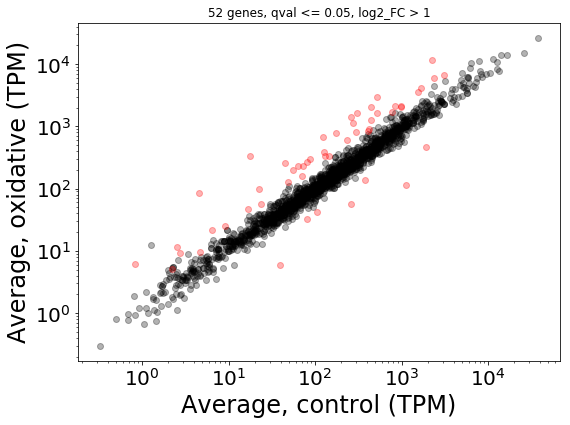

In [39]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
x_data = df_compact.loc[df_compact['qval'] > 0.05]['avg(SQ1,SQ3,SQ5)']
y_data = df_compact.loc[df_compact['qval'] > 0.05]['avg(SQ2,SQ4,SQ6)']
ax1.loglog(x_data, y_data, 'ko', alpha=0.3)
x_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) < 1.)]['avg(SQ1,SQ3,SQ5)']
y_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) < 1.)]['avg(SQ2,SQ4,SQ6)']
ax1.loglog(x_data, y_data, 'ko', alpha=0.3)
x_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['avg(SQ1,SQ3,SQ5)']
y_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['avg(SQ2,SQ4,SQ6)']
ax1.loglog(x_data, y_data, 'ro', alpha=0.3)

ax1.tick_params(labelsize=20)
ax1.set_xlabel('Average, control (TPM)', fontsize=24)
ax1.set_ylabel('Average, oxidative (TPM)', fontsize=24)
ax1.set_title('{} genes, qval <= 0.05, log2_FC > 1'.format(len(y_data)))
plt.tight_layout()
print(len(x_data))
print(stats.linregress(np.log(x_data), np.log(y_data)))

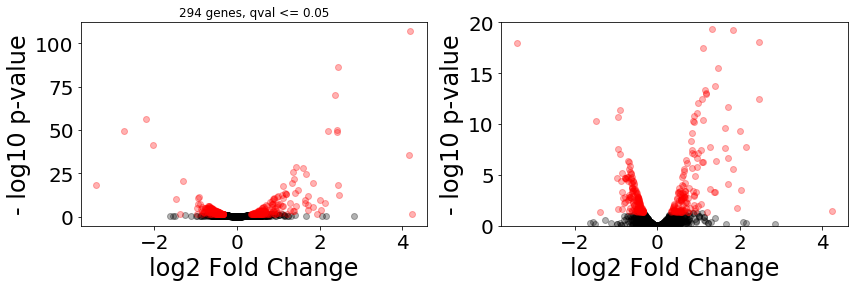

In [40]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
x_data = df_compact.loc[df_compact['qval'] > 0.05]['log2_FC']
y_data = df_compact.loc[df_compact['qval'] > 0.05]['qval']
ax1.plot(x_data, np.abs(np.log10(y_data)), 'ko', alpha=0.3)
x_data = df_compact.loc[df_compact['qval'] <= 0.05]['log2_FC']
y_data = df_compact.loc[df_compact['qval'] <= 0.05]['qval']
ax1.plot(x_data, np.abs(np.log10(y_data)), 'ro', alpha=0.3)

# ax1.set_ylim(0,20)
ax1.tick_params(labelsize=20)
ax1.set_xlabel('log2 Fold Change', fontsize=24)
ax1.set_ylabel('- log10 p-value', fontsize=24)

ax2 = fig.add_subplot(122)
x_data = df_compact.loc[df_compact['qval'] > 0.05]['log2_FC']
y_data = df_compact.loc[df_compact['qval'] > 0.05]['qval']
ax2.plot(x_data, np.abs(np.log10(y_data)), 'ko', alpha=0.3)
x_data = df_compact.loc[df_compact['qval'] <= 0.05]['log2_FC']
y_data = df_compact.loc[df_compact['qval'] <= 0.05]['qval']
ax2.plot(x_data, np.abs(np.log10(y_data)), 'ro', alpha=0.3)

ax2.set_ylim(0,20)
ax2.tick_params(labelsize=20)
ax2.set_xlabel('log2 Fold Change', fontsize=24)
ax2.set_ylabel('- log10 p-value', fontsize=24)
plt.tight_layout()
ax1.set_title('{} genes, qval <= 0.05'.format(len(y_data)))

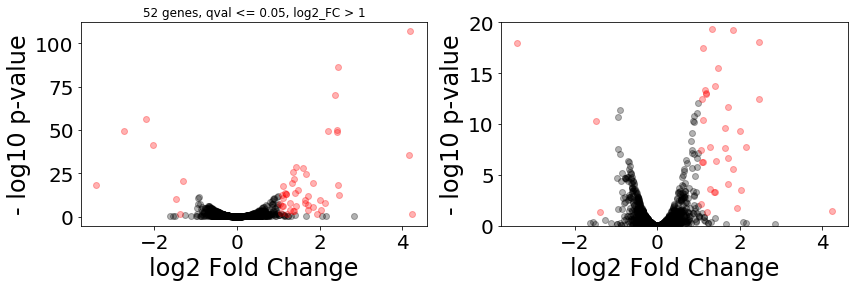

In [41]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
x_data = df_compact.loc[(df_compact['qval'] > 0.05)]['log2_FC']
y_data = df_compact.loc[(df_compact['qval'] > 0.05)]['qval']
ax1.plot(x_data, np.abs(np.log10(y_data)), 'ko', alpha=0.3)
x_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) < 1.)]['log2_FC']
y_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) < 1.)]['qval']
ax1.plot(x_data, np.abs(np.log10(y_data)), 'ko', alpha=0.3)
x_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['log2_FC']
y_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['qval']
ax1.plot(x_data, np.abs(np.log10(y_data)), 'ro', alpha=0.3)

ax1.tick_params(labelsize=20)
ax1.set_xlabel('log2 Fold Change', fontsize=24)
ax1.set_ylabel('- log10 p-value', fontsize=24)

ax2 = fig.add_subplot(122)
x_data = df_compact.loc[(df_compact['qval'] > 0.05)]['log2_FC']
y_data = df_compact.loc[(df_compact['qval'] > 0.05)]['qval']
ax2.plot(x_data, np.abs(np.log10(y_data)), 'ko', alpha=0.3)
x_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) < 1.)]['log2_FC']
y_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) < 1.)]['qval']
ax2.plot(x_data, np.abs(np.log10(y_data)), 'ko', alpha=0.3)
x_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['log2_FC']
y_data = df_compact.loc[(df_compact['qval'] <= 0.05) & (np.abs(df_compact['log2_FC']) >= 1.)]['qval']
ax2.plot(x_data, np.abs(np.log10(y_data)), 'ro', alpha=0.3)

ax2.set_ylim(0,20)
ax2.tick_params(labelsize=20)
ax2.set_xlabel('log2 Fold Change', fontsize=24)
ax2.set_ylabel('- log10 p-value', fontsize=24)
plt.tight_layout()
ax1.set_title('{} genes, qval <= 0.05, log2_FC > 1'.format(len(y_data)))